# Introduction

**1. Goal**
    
    Dự đoán melanoma là một loại ung thư da, ít phổ biến nhưng rất nguy hiểm, chỉ chiếm khoảng 1% các cases, nhưng lại chiếm phần lớn ca tử vong trong số các loại ung thư da

**2. Based on medical knowledge **

    * Melanoma phổ biến ở nam và nữ độ tuổi 20-39
    * In the U.S., melanoma continues to be
        + the fifth most common cancer in men of all age groups
        + the sixth most common cancer in women of all age groups
    * The world’s highest incidence of melanoma is in Australia and New Zealand (more than twice as high as in North America)
    
    
**3. Data and Overview**
    * Purpose: dự đoán benign và malignant
    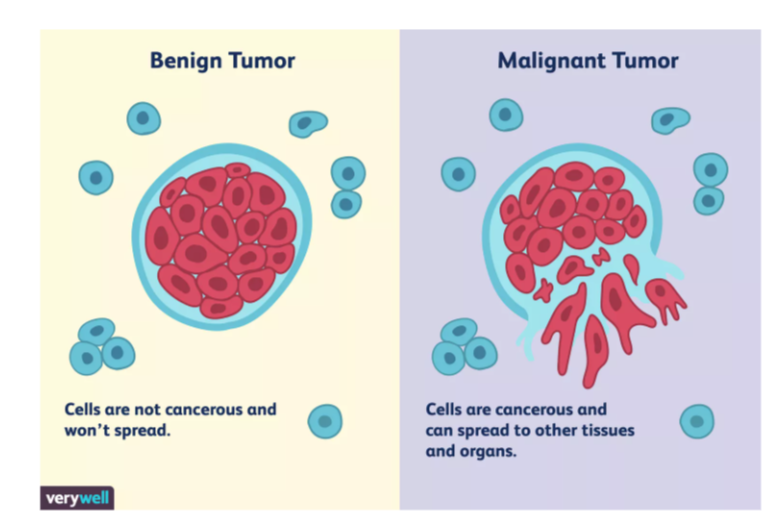
    * Data:
    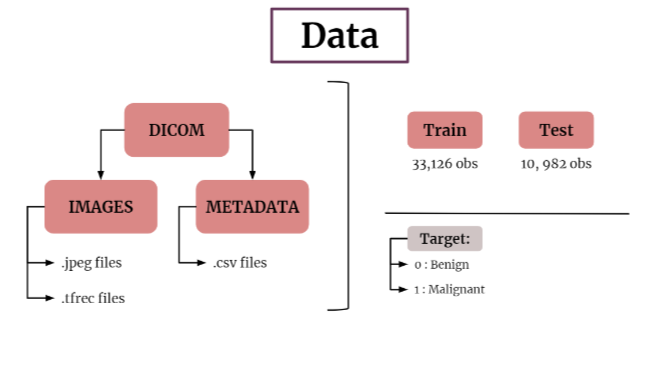
        
        + .dcm files: chứa hình ảnh từ quá trình medical scan (ảnh siêu âm, MRI,..) và thông tin về patient

        + .jpeg files: the DICOM files converted into .jpeg format
        
        + .tfrec files: được sử dụng bởi tensorflow, is a simple record-oriented binary format for ML training data
        
        
**4. Explain features**
    
    * image_name: unique identifier, points to filename of related DICOM image
    * patient_id: unique patient identifier
    * sex: the sex of the patient (when unknown, will be blank)
    * age_approx: approximate patient age at time of imaging
    * anatom_site_general_challenge: location of imaged site (head, neck, hand,...)
    * diagnosis: detailed diagnosis information (train only) (nevus, melanoma,..)
    * benign_malignant: indicator of malignancy of imaged lesion
    * target: binarized version of the target variable


# Libraries

In [1]:
!pip install -q efficientnet_pytorch
import numpy as np 
import pandas as pd 
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import os
from sklearn.metrics import auc,roc_auc_score
device = torch.device("cpu")
import warnings
warnings.filterwarnings("ignore")
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
import time
import datetime
import warnings
import random
import gc
import pickle
! pip install -Uqq fastbook
from fastbook import *
import seaborn as sns

# LOAD DATA

In [2]:
os.listdir("../input/siim-isic-melanoma-classification")

['sample_submission.csv',
 'jpeg',
 'tfrecords',
 'train.csv',
 'test.csv',
 'test',
 'train']

In [3]:
def load_data():
    IMAGE_PATH = "../input/siim-isic-melanoma-classification/"
    
    train_df = pd.read_csv(IMAGE_PATH + 'train.csv')
    
    return train_df


In [4]:
train_df = load_data()

In [5]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [7]:
print("For train set:", train_df.shape)

For train set: (33126, 8)
For test set: (10982, 5)


In [8]:
def col_info(df):
    null_counts = df.isnull().sum()
    unique_counts = df.nunique()
    percentage = round((null_counts / len(df))*100, 2)

    most_frequent_values = []
    max_percentages = []
    data_types = []

    for column in df.columns:
        # Adding data type of each column
        data_types.append(df[column].dtype)

        value_counts = df[column].value_counts()
        most_frequent_value = value_counts.idxmax() if not value_counts.empty else None
        max_count = value_counts.iloc[0] if not value_counts.empty else None
        max_percentage = (max_count / len(df)) * 100 if max_count is not None else None

        most_frequent_values.append(most_frequent_value)
        max_percentages.append(max_percentage)

    # Preparing the column summary with additional details
    column_summary = pd.DataFrame({
        'Data Type': data_types,
        'Null Count': null_counts,
        'Unique values': unique_counts,
        'Null Percentage': percentage,
        'Most frequent value': most_frequent_values,
        'Max occurrence percentage': max_percentages
    })
        
    return column_summary

In [9]:
col_info(train_df)

,Data Type,Null Count,Unique values,Null Percentage,Most frequent value,Max occurrence percentage
image_name,object,0,33126,0.00,ISIC_2637011,0.003019
patient_id,object,0,2056,0.00,IP_7279968,0.347159
sex,object,65,2,0.20,male,51.560708
age_approx,float64,68,18,0.21,45.0,13.481857
anatom_site_general_challenge,object,527,6,1.59,torso,50.851295
diagnosis,object,0,9,0.00,unknown,81.881302
benign_malignant,object,0,2,0.00,benign,98.237034
target,int64,0,2,0.00,0,98.237034


# FUNCTION

In [11]:
def plot_count_by_target_bar(df, columns, target='target'):
    for col in columns:
        plt.figure(figsize=(12, 6)) 
        ax = sns.countplot(data=df, x=col, hue=target)
        plt.xticks(rotation=45)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        for p in ax.patches:
            ax.annotate(str(p.get_height()), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', 
                        va='center',
                        xytext=(0, 5), 
                        textcoords='offset points')
        plt.show()

In [12]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.target == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.target == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['target'] == 0].dropna(),
                         label='0', hist = False, color='blue')
            sns.distplot(data_to_plot[column_name][data['target'] == 1].dropna(),
                         label='1', hist = False, color='red')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='target', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='target', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show() 

In [13]:
def plot_missing_feature_by_target(dataframe, feature, target):
    missing_feature = dataframe[dataframe[feature].isnull()]

    missing_feature_target_counts = missing_feature[target].value_counts()

    target_values = dataframe[target].unique()
    for val in target_values:
        if val not in missing_feature_target_counts:
            missing_feature_target_counts[val] = 0

    missing_feature_target_counts = missing_feature_target_counts.sort_index()
    plt.figure(figsize=(8, 6))
    ax = missing_feature_target_counts.plot(kind='bar')
    plt.title(f'Missing {feature} Values by {target}')
    plt.xlabel('Target')
    plt.ylabel('Count of missing values')
    plt.xticks(rotation=0)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='bottom',
                    xytext=(0, 2), 
                    textcoords='offset points')

    plt.show()


In [14]:
def plot_value_counts(dataframe, column):
    value_counts = dataframe[column].value_counts()

    plt.figure(figsize=(12, 6))
    ax = value_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Value Counts of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=360)

    for p in ax.patches:
        ax.annotate(str(p.get_height()), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center',
                    xytext=(0, 5), 
                    textcoords='offset points')

    plt.show()


In [15]:
def calculate_statistics(dataframe, column):
    mean = dataframe[column].mean()
    median = dataframe[column].median()
    mode = dataframe[column].mode()[0] 
    return {"mean": mean, "median": median, "mode": mode}

In [49]:
def plot_count(df, feature, title='', size=2, rotate_axis=False):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    # Chỉ định DataFrame và cột bằng tham số `x`
    sns.countplot(x=feature, data=df, order=df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    if rotate_axis:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()


## HANDEL MISSING VALUES

# TRAIN SET

# SEX

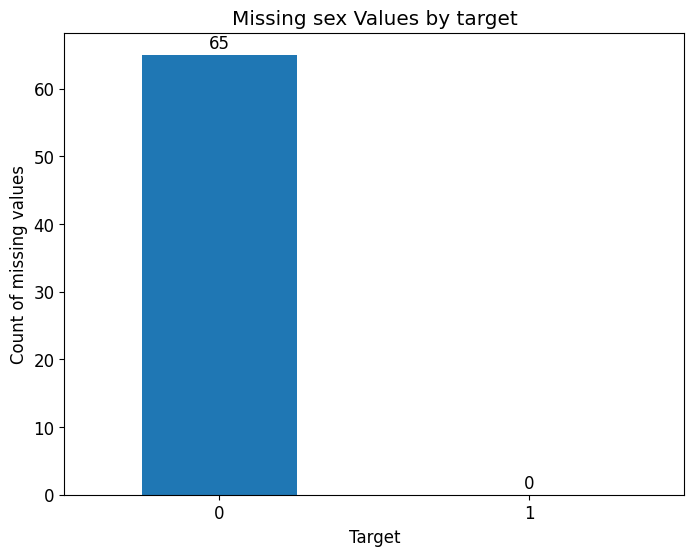

In [16]:
plot_missing_feature_by_target(train_df, 'sex', 'target')

Tất cả missing values trong sex đều là begin --> sử dụng giới tính chiếm nhiều hơn để quy định các missing values

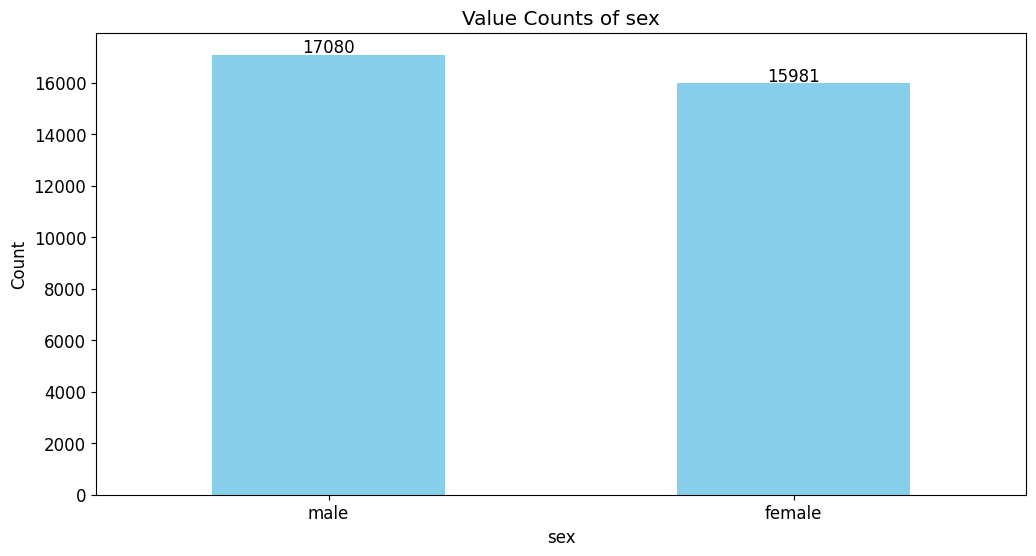

In [17]:
plot_value_counts(train_df, 'sex')

In [18]:
train_df['sex'].fillna("male", inplace = True) 

# AGE

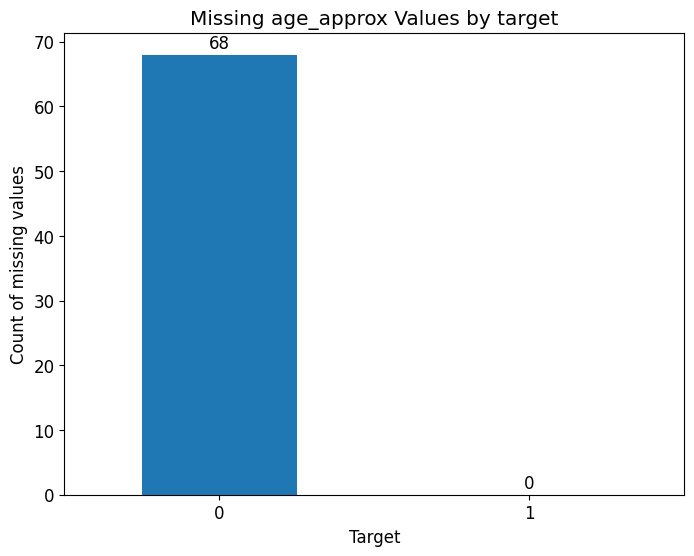

In [19]:
plot_missing_feature_by_target(train_df, 'age_approx','target')

In [20]:
calculate_statistics(train_df, 'age_approx')

{'mean': 48.87001633492649, 'median': 50.0, 'mode': 45.0}

Mean và median của age đều gần bằng 50, mode thì bằng 45
distribution là normal => sử dụng median 

In [21]:
train_df['age_approx'].fillna(train_df['age_approx'].median(), inplace = True) 

# ANATOMY

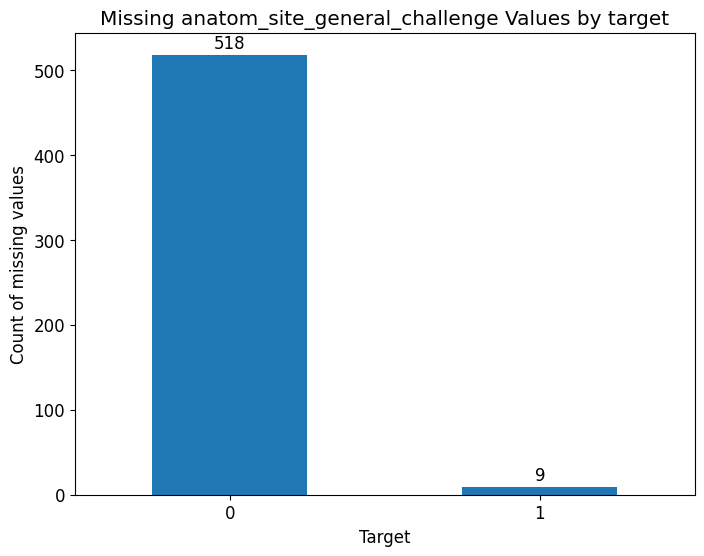

In [22]:
plot_missing_feature_by_target(train_df, 'anatom_site_general_challenge','target')

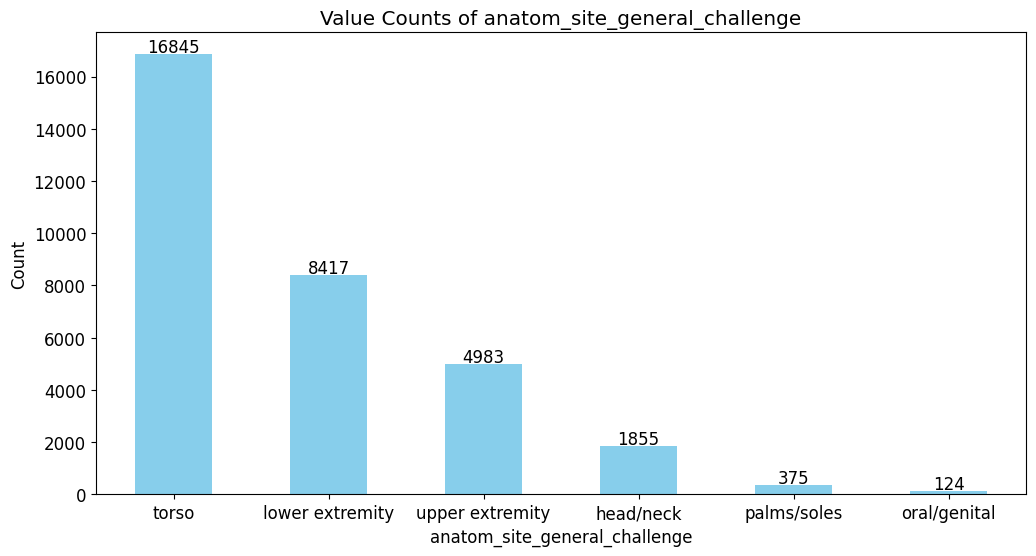

In [23]:
plot_value_counts(train_df, 'anatom_site_general_challenge')

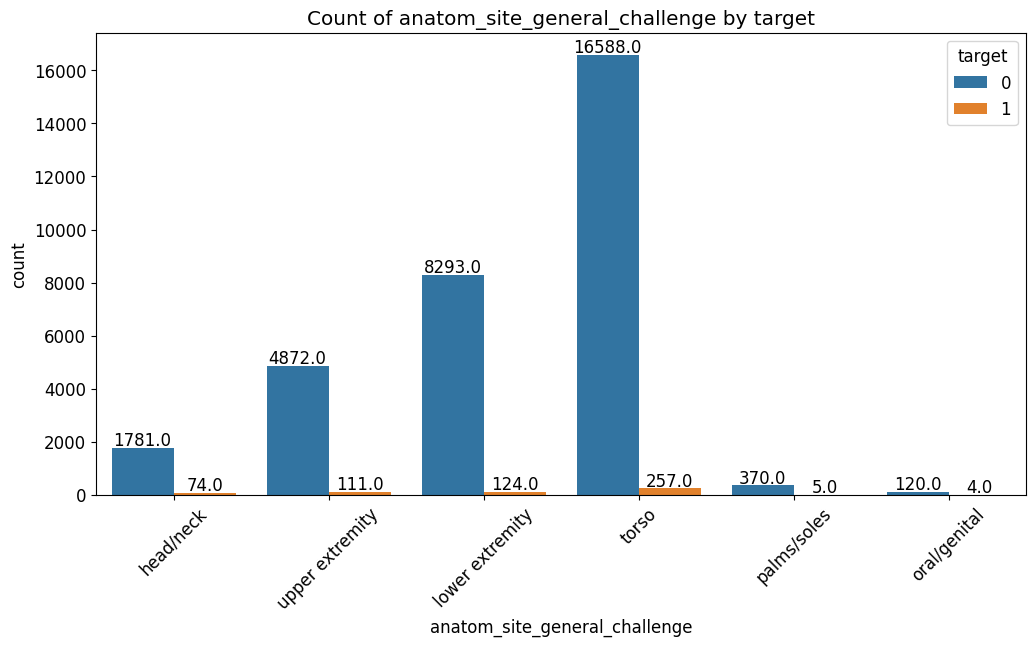

In [24]:
plot_count_by_target_bar(train_df, ['anatom_site_general_challenge'])

Trong missing values, có 9 malignant cases, 518 benign cases
=> sử dụng most frequent: torso

In [25]:
train_df['anatom_site_general_challenge'].fillna('torso', inplace = True) 

Phần lớn missing values ở cột anatomy đều là 70 tuổi --> Select most frequent anatomy for age 70

# Removed Duplicates

In [29]:
path = "../input/2020-challenge-duplicates-dataset/2020_Challenge_duplicates.csv"
duplicates_df = pd.read_csv(path)

In [30]:
duplicates_df.head()

,ISIC_id,ISIC_id_paired,partition
0,ISIC_0079038,ISIC_8521950,train
1,ISIC_0087297,ISIC_4755972,train
2,ISIC_0088137,ISIC_4201955,train
3,ISIC_0112097,ISIC_5934021,train
4,ISIC_0148783,ISIC_7460560,train


In [31]:
duplicates_train_df = duplicates_df[duplicates_df['partition'] == 'train']

duplicates_train_df.reset_index(inplace=True, drop=True)

In [32]:
remove_train = list(duplicates_train_df['ISIC_id'].values)

In [33]:
train_df = train_df[~train_df['image_name'].isin(remove_train)]

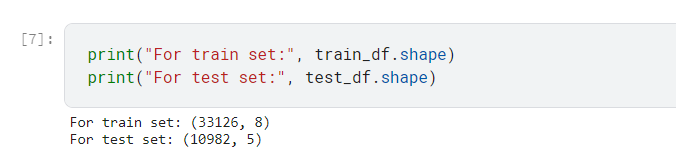

In [34]:
print(train_df.shape)

(32701, 8)
(10875, 5)


In [38]:
train_df.to_csv('train_df_cleaned.csv', index=False)


# EDA

# TRAIN SET

# TARGET

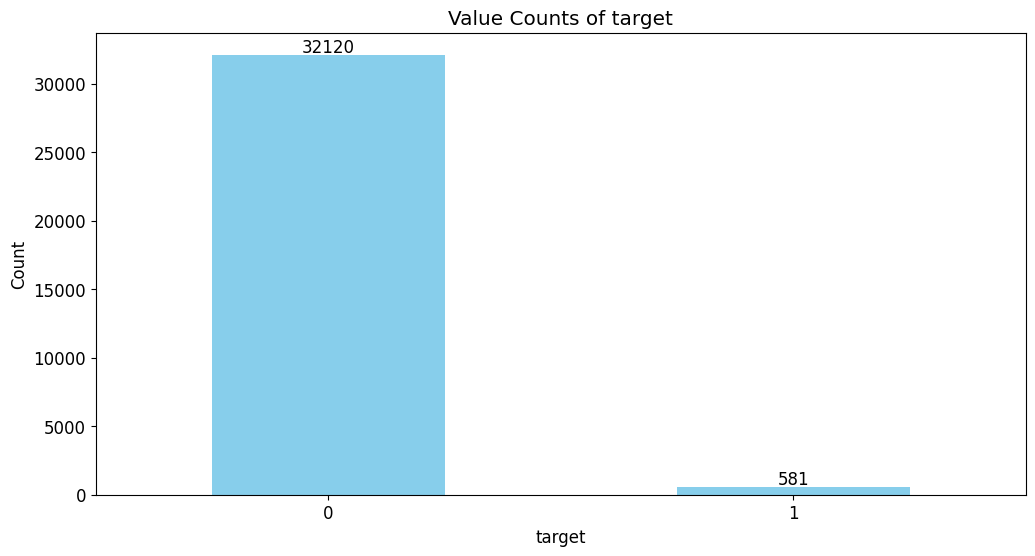

In [35]:
plot_value_counts(train_df, 'target')

98% là 0, 2% là 1 
=> Soluction:
+ Oversampling: of the minority class, increasing the number of images through augmentations
+ Understampling: of the majority class (we shall see how the process is going)

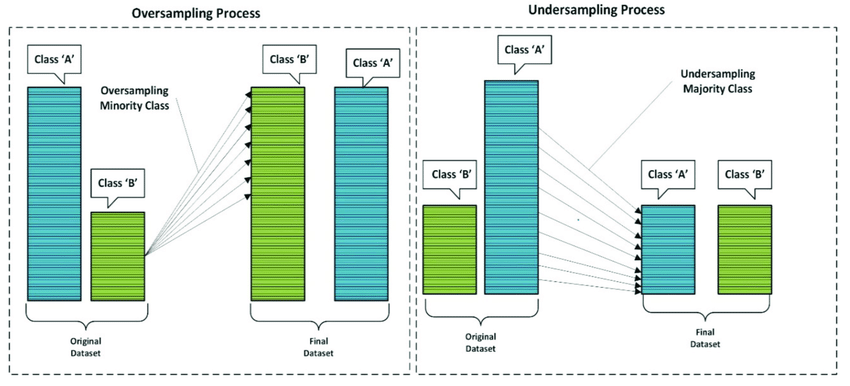

# AGE

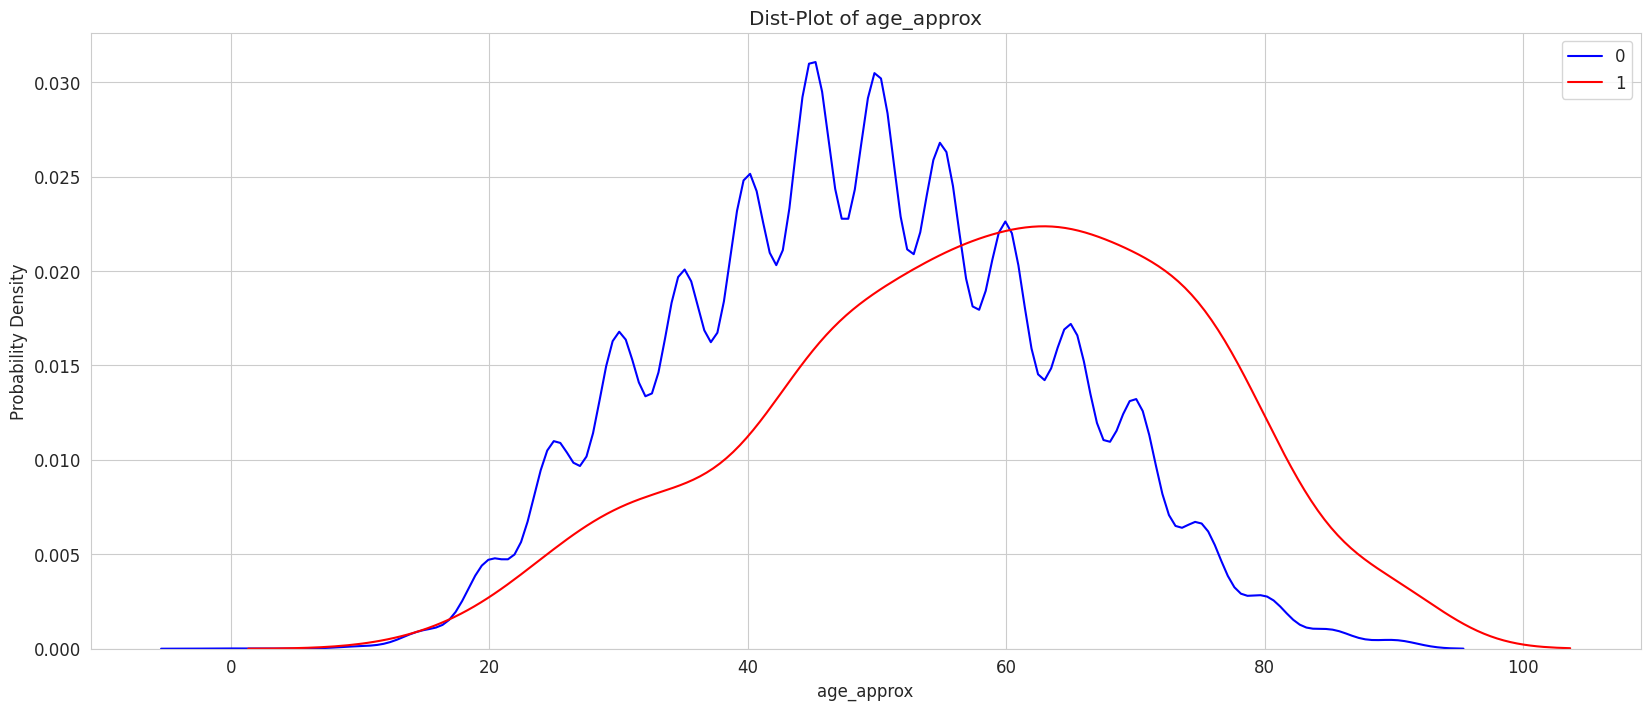

In [39]:
plot_continuous_variables(train_df, 'age_approx', plots =['distplot'])

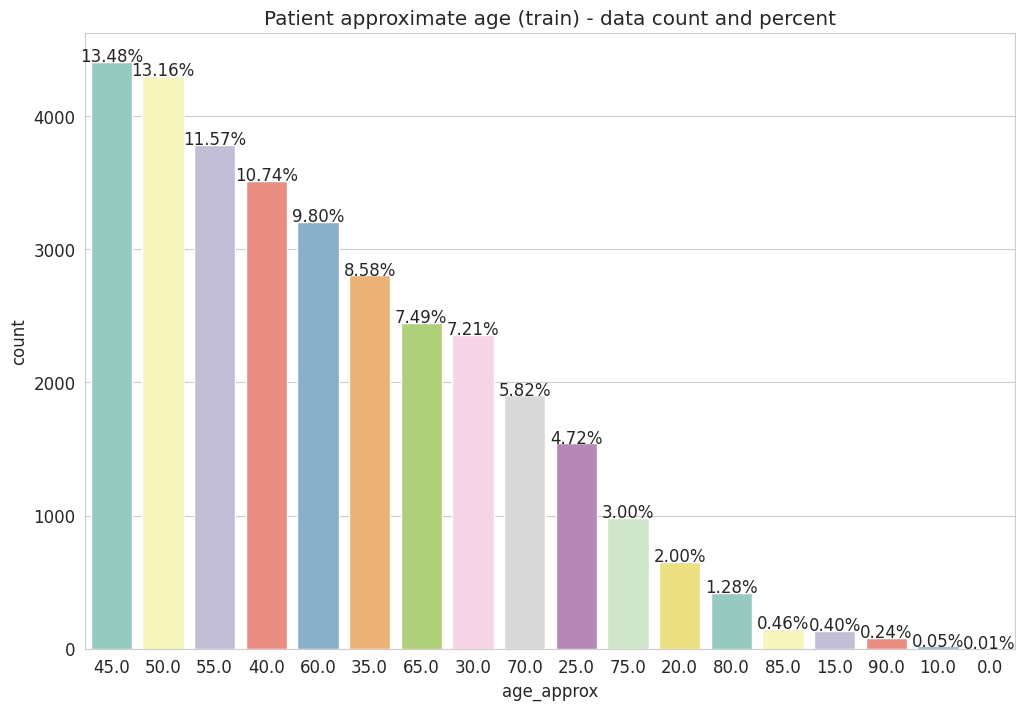

In [52]:
plot_count(train_df, 'age_approx', 'Patient approximate age (train) - data count and percent', size=4)

# SEX

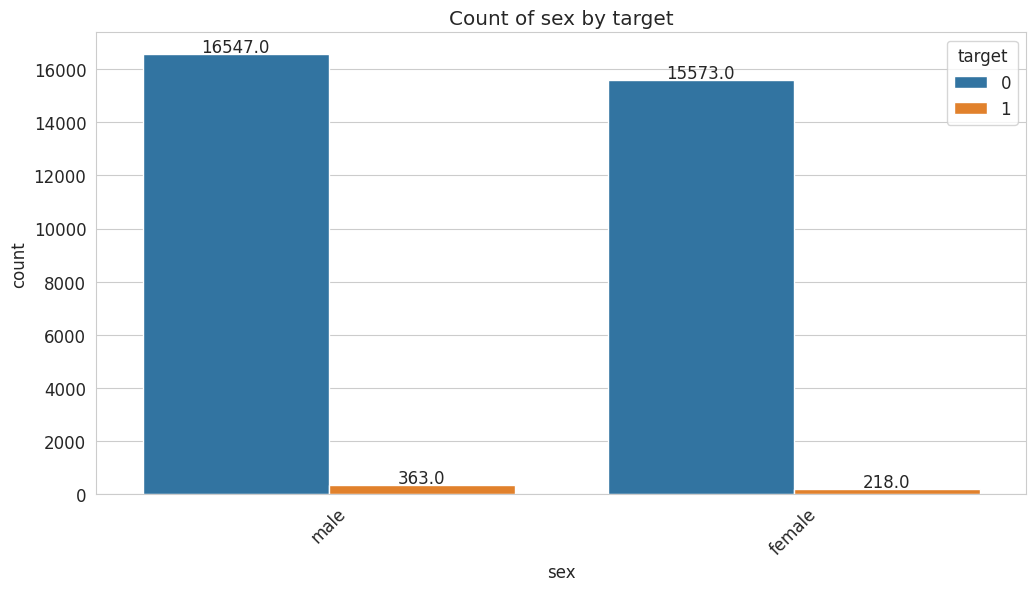

In [40]:
plot_count_by_target_bar(train_df, ['sex'])

# 'anatom_site_general_challenge

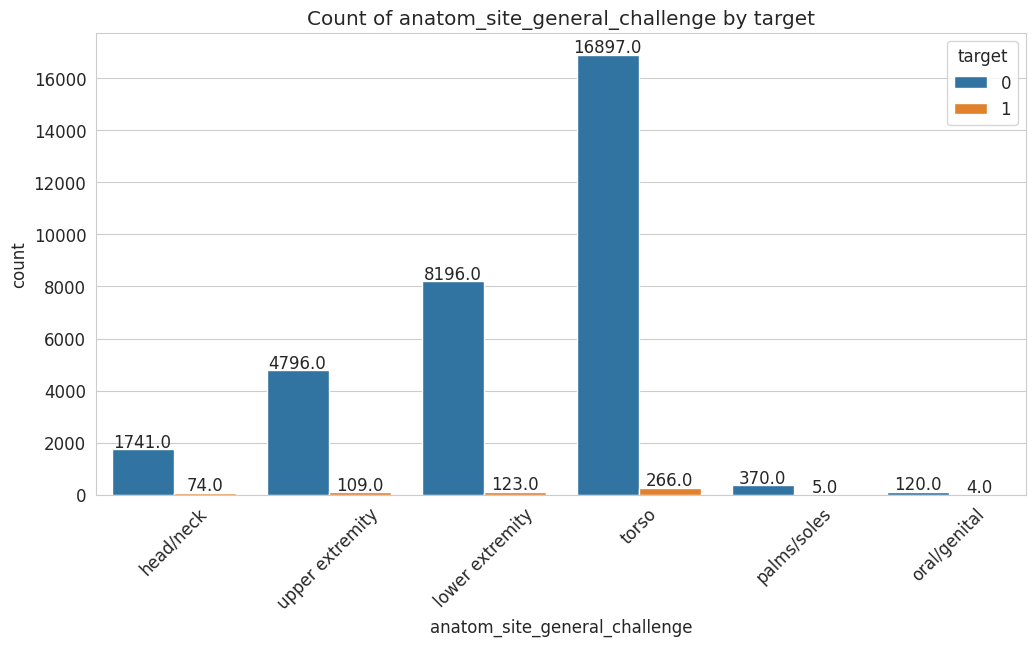

In [41]:
plot_count_by_target_bar(train_df, ['anatom_site_general_challenge'])

# diagnosis

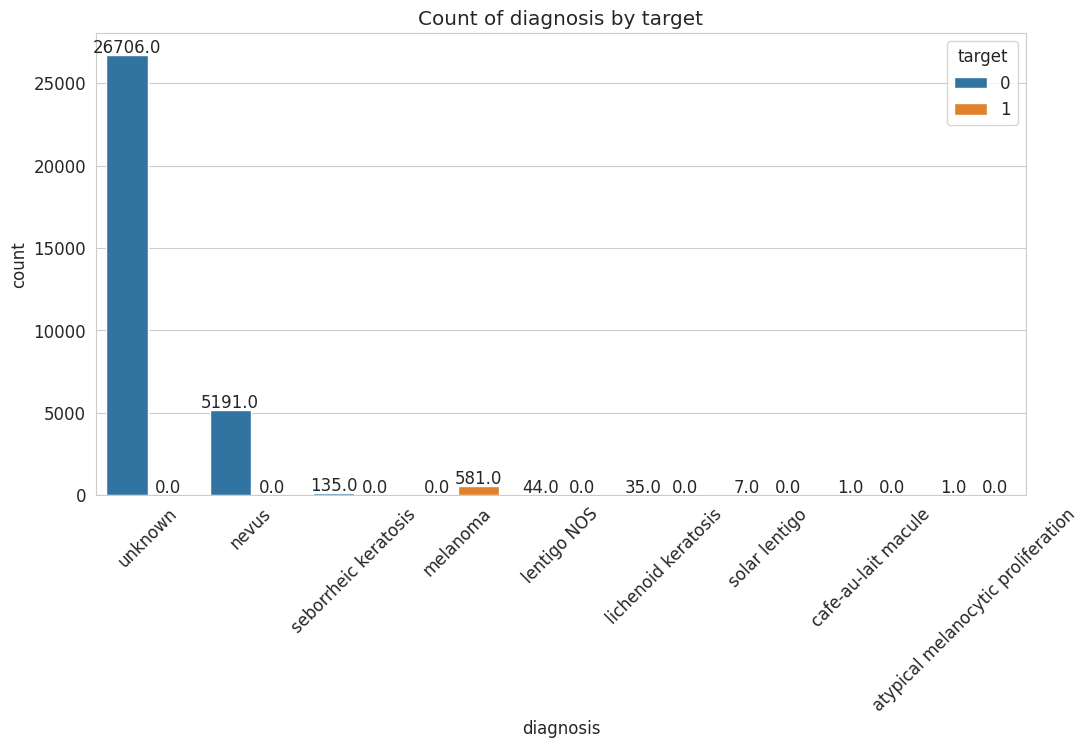

In [42]:
plot_count_by_target_bar(train_df, ['diagnosis'])